In [1]:
!pip install git+https://github.com/qubvel/classification_models.git
!pip install keras-radam
!pip install adabelief-tf==0.1.0
!pip install keras-rectified-adam
!pip install keras-adabound
!pip install git+https://github.com/tensorflow/addons
!pip install resampy

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-waze7kzu
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-waze7kzu
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/tensorflow/addons to /tmp/pip-req-build-yg9qb2qo
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/addons /tmp/pip-req-build-yg9qb2qo
  Resolved https://github.com/tensorflow/addons to commit 5dd5f65827c37e9b9b616b79ed93da856b57ffe5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from classification_models.keras import Classifiers
import numpy as np
np.random.seed(123)  # for reproducibility
import IPython.display as ipd
import librosa
import os
import librosa.display
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Embedding
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from adabelief_tf import AdaBeliefOptimizer
from keras_radam.training import RAdamOptimizer
from keras_adabound import AdaBound
import tensorflow_addons
from keras.layers import LSTM,Input

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/UrbanSound8K/audio/', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [6]:
df = create_dataset_df('/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/content/drive/MyDrive/UrbanSound8K/audio/fold...
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/audio/fold...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/audio/fold...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/audio/fold...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/audio/fold...


In [7]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling',
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [8]:
df['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [9]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [11]:
extracted_features=[]
for i in range(8732):
    file_name = '/content/drive/MyDrive/UrbanSound8K/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
    final_class_labels=df["class"][i]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [12]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

y=np.array(pd.get_dummies(y))

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=0,stratify=y)
num_labels=y.shape[1]

In [13]:
X_train = X_train.reshape(7422,1, 40)
print(X_train.shape)
print(X_train)

(7422, 1, 40)
[[[-2.76979309e+02  1.73746094e+02 -4.13307114e+01 ... -3.23052597e+00
   -1.50618470e+00 -1.10234596e-01]]

 [[-1.77563065e+02  5.43005562e+01 -1.99646511e+01 ...  1.89738810e-01
   -2.82316899e+00  8.39156330e-01]]

 [[-8.28932190e+01 -4.72285223e+00 -3.03000336e+01 ...  4.07694787e-01
   -5.19276476e+00  1.88034797e+00]]

 ...

 [[-2.94210724e+02  1.84623718e+02  3.66914978e+01 ... -4.78537226e+00
   -3.36941898e-01 -3.86271858e+00]]

 [[-1.54763260e+02  1.83913895e+02 -7.21948776e+01 ... -2.45711923e-01
   -7.43238151e-01 -9.36451495e-01]]

 [[-1.29209183e+02  2.19333359e+02 -9.20748520e+01 ... -1.41605616e-01
   -2.18898273e+00 -1.22147484e-03]]]


In [14]:
y_train = y_train.reshape(7422,1, 10)
print(y_train.shape)
print(y_train)

(7422, 1, 10)
[[[0 0 0 ... 0 1 0]]

 [[0 0 0 ... 1 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 1 0]]

 [[0 0 0 ... 0 1 0]]]


In [15]:
X_test = X_test.reshape(1310,1, 40)
print(X_test.shape)
print(X_test)

(1310, 1, 40)
[[[-1.7842403e+02  1.4371432e+02 -2.0868265e+01 ...  2.1344268e+00
    1.9732285e+00  1.4082223e+00]]

 [[-5.0106845e+02  1.0496333e+02 -1.6483179e+01 ...  1.4531004e+00
    6.7950785e-01 -7.7373183e-01]]

 [[-9.6208115e+01  1.2927138e+02 -3.3690033e+01 ...  4.3075600e+00
    5.1345506e+00 -1.6533900e+00]]

 ...

 [[-4.0501535e+02  1.5065727e+02  3.0020544e+01 ... -2.3421803e+00
   -4.6613317e+00 -2.8283858e+00]]

 [[-1.0463602e+02  9.1478966e+01 -2.0475727e+01 ...  2.6983185e+00
   -4.2380648e+00  2.5321250e+00]]

 [[-4.4352841e+02  1.1238751e+02 -3.9583145e+01 ...  6.0430515e-01
   -4.3045373e+00 -3.6535767e-01]]]


In [16]:
y_test = y_test.reshape(1310,1,10)
print(y_test.shape)
print(y_test)

(1310, 1, 10)
[[[0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]]]


In [17]:
from keras.layers import LSTM,Input

# Model
model = Sequential()
model.add(LSTM(40,input_shape=(1,40), return_sequences=True))
model.add(LSTM(40,input_shape=(1,40),return_sequences=True))
model.add(Dense(512,activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation ='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 40)             12960     
                                                                 
 lstm_1 (LSTM)               (None, 1, 40)             12960     
                                                                 
 dense (Dense)               (None, 1, 512)            20992     
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 dense_1 (Dense)             (None, 1, 10)             5130      
                                                                 
Total params: 52,042
Trainable params: 52,042
Non-trainable params: 0
_________________________________________________________________


In [20]:
k = []
ok = 0
yes = 0
zet = 0
yep = 0


opt =  [keras.optimizers.Adam(learning_rate=0.001),
                  keras.optimizers.SGD(learning_rate=0.01),
                  keras.optimizers.Nadam(learning_rate=0.001),
                  keras.optimizers.RMSprop(learning_rate=0.001),
                  RAdamOptimizer(learning_rate=0.001),
                  tensorflow_addons.optimizers.yogi.Yogi(learning_rate=0.001)]

for t in opt:
    del model
    #del base_model
    #del x
    #del output
    if (t == opt[0]):
        print("-------------------------------------optimizer = Adam-------------------------------------")
    elif (t == opt[1]):
            print("-------------------------------------optimizer = SGD-------------------------------------")
    elif (t == opt[2]):
            print("-------------------------------------optimizer = Nadam-------------------------------------")
    elif (t == opt[3]):
            print("-------------------------------------optimizer = RMSprop-------------------------------------")
    elif (t == opt[4]):
            print("-------------------------------------optimizer = RAdam-------------------------------------")

    elif (t == opt[5]):
            print("-------------------------------------optimizer = Yogi-------------------------------------")

    model = Sequential()
    model.add(LSTM(40,input_shape=(1,40), return_sequences=True))
    model.add(LSTM(40,input_shape=(1,40),return_sequences=True))
    model.add(Dense(512,activation ='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10,activation ='softmax'))
    # 8. Compile model
    model.compile(loss='categorical_crossentropy',
              optimizer = t,
              metrics=['accuracy'])


       # 9. Fit model on training data
    k.append(model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test),verbose=1))


-------------------------------------optimizer = Adam-------------------------------------
Epoch 1/100
232/232 [==============================] - 8s 10ms/step - loss: 1.7806 - accuracy: 0.3740 - val_loss: 1.4475 - val_accuracy: 0.5130
Epoch 2/100
232/232 [==============================] - 2s 8ms/step - loss: 1.2493 - accuracy: 0.5771 - val_loss: 1.1956 - val_accuracy: 0.6061
Epoch 3/100
232/232 [==============================] - 2s 9ms/step - loss: 1.0718 - accuracy: 0.6477 - val_loss: 1.0698 - val_accuracy: 0.6405
Epoch 4/100
232/232 [==============================] - 2s 10ms/step - loss: 0.9410 - accuracy: 0.6951 - val_loss: 0.9522 - val_accuracy: 0.6954
Epoch 5/100
232/232 [==============================] - 1s 6ms/step - loss: 0.8570 - accuracy: 0.7241 - val_loss: 0.9441 - val_accuracy: 0.7099
Epoch 6/100
232/232 [==============================] - 1s 6ms/step - loss: 0.7866 - accuracy: 0.7495 - val_loss: 0.8715 - val_accuracy: 0.7382
Epoch 7/100
232/232 [============================

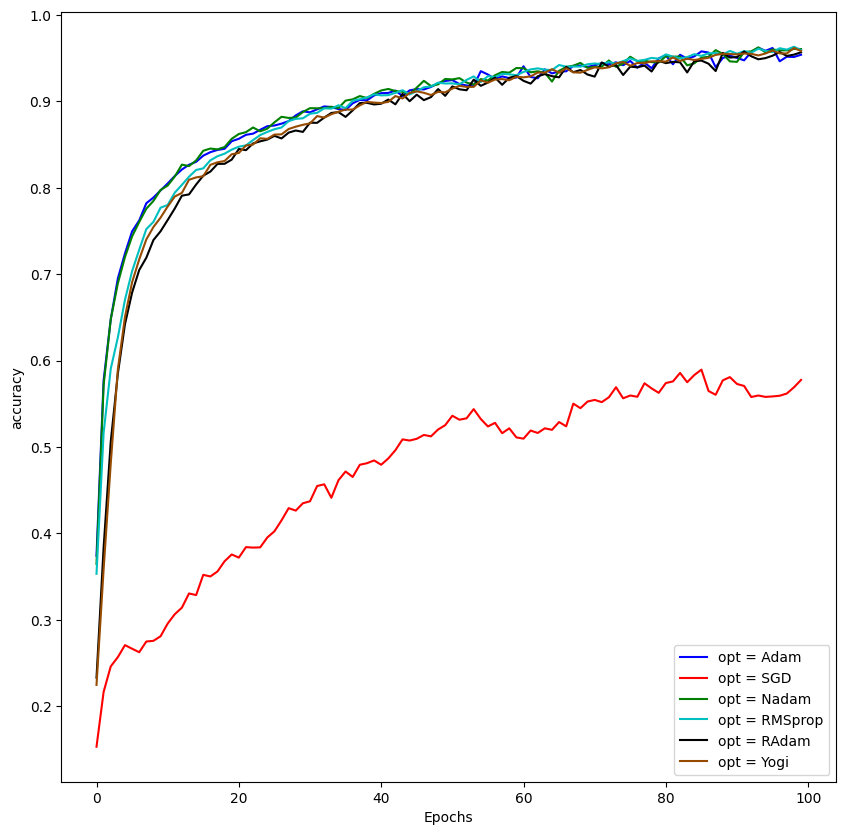

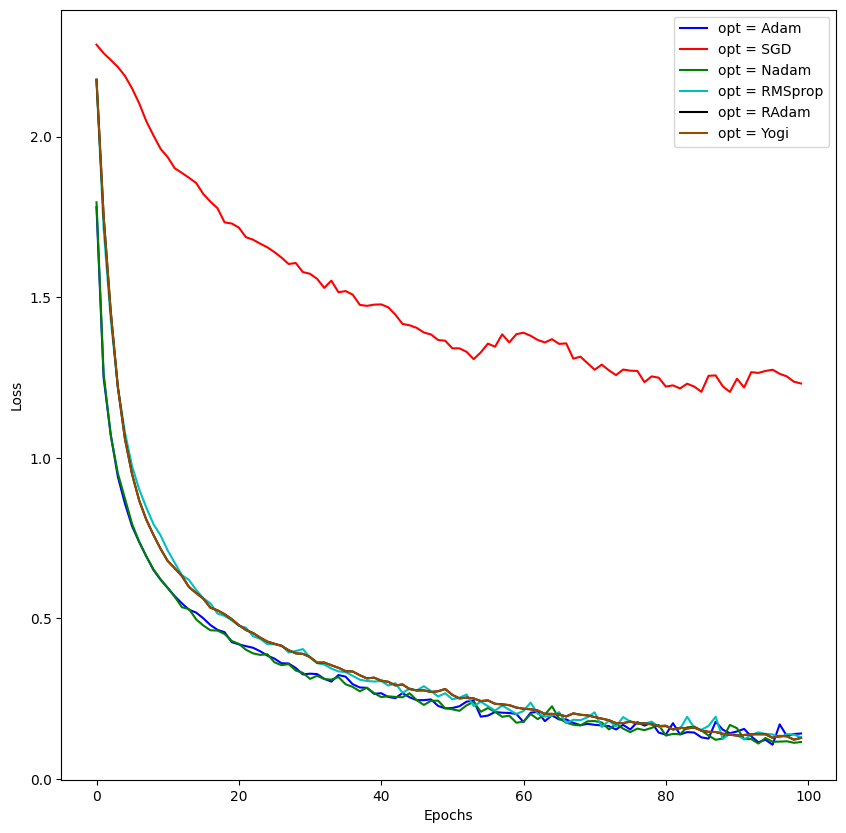

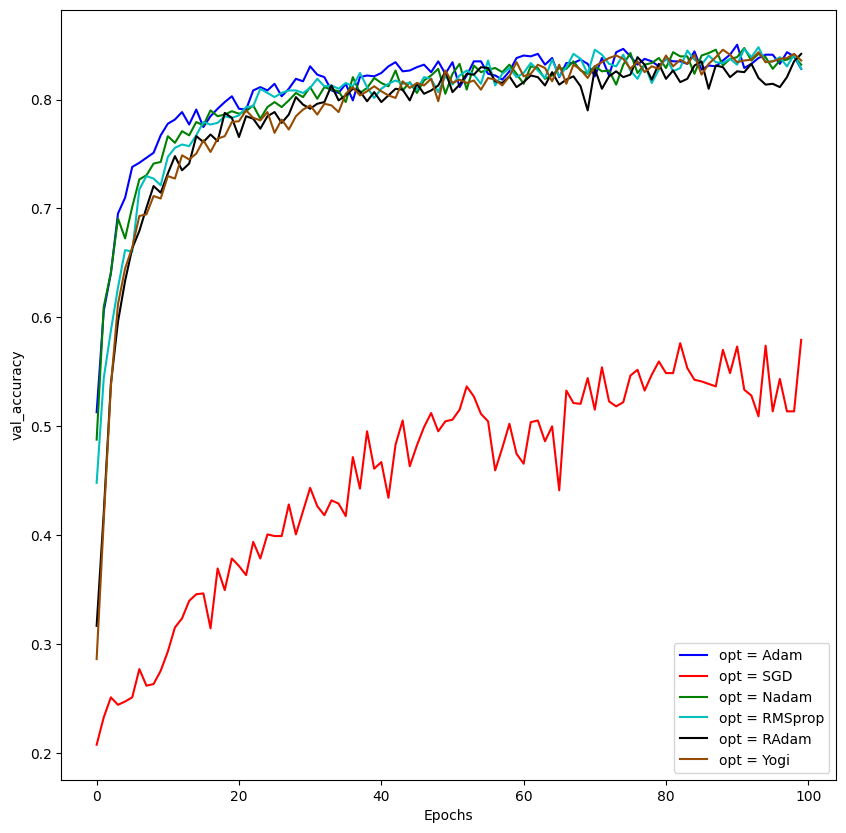

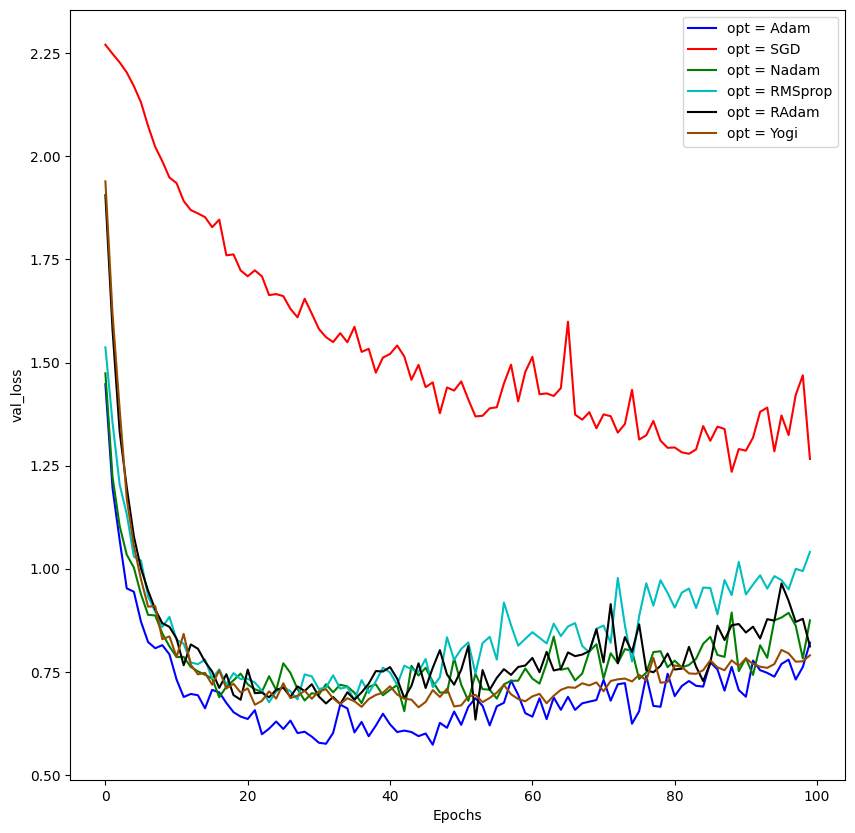

In [21]:
while (ok<len(k)):



    plt.figure(figsize=(10,10))
    plt.plot(k[ok+0].history['accuracy'],color='b', label="opt = Adam")
    plt.plot(k[ok+1].history['accuracy'],color='r', label="opt = SGD")
    plt.plot(k[ok+2].history['accuracy'],color='g', label="opt = Nadam")
    plt.plot(k[ok+3].history['accuracy'],color='c', label="opt = RMSprop")
    plt.plot(k[ok+4].history['accuracy'],color='k', label="opt = RAdam")
    plt.plot(k[ok+5].history['accuracy'],color='#964B00', label="opt = Yogi")

    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    ok +=6







while (yes<len(k)):



    plt.figure(figsize=(10,10))
    plt.plot(k[yes+0].history['loss'],color='b', label="opt = Adam")
    plt.plot(k[yes+1].history['loss'],color='r', label="opt = SGD")
    plt.plot(k[yes+2].history['loss'],color='g', label="opt = Nadam")
    plt.plot(k[yes+4].history['loss'],color='c', label="opt = RMSprop")
    plt.plot(k[yes+5].history['loss'],color='k', label="opt = RAdam")
    plt.plot(k[yes+5].history['loss'],color='#964B00', label="opt = Yogi")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    yes+=6




while (zet<len(k)):



    plt.figure(figsize=(10,10))
    plt.plot(k[zet+0].history['val_accuracy'],color='b', label="opt = Adam")
    plt.plot(k[zet+1].history['val_accuracy'],color='r', label="opt = SGD")
    plt.plot(k[zet+2].history['val_accuracy'],color='g', label="opt = Nadam")
    plt.plot(k[zet+3].history['val_accuracy'],color='c', label="opt = RMSprop")
    plt.plot(k[zet+4].history['val_accuracy'],color='k', label="opt = RAdam")
    plt.plot(k[zet+5].history['val_accuracy'],color='#964B00', label="opt = Yogi")

    plt.xlabel('Epochs')
    plt.ylabel('val_accuracy')
    plt.legend()
    plt.show()

    zet+=6





while (yep<len(k)):



    plt.figure(figsize=(10,10))
    plt.plot(k[yep+0].history['val_loss'],color='b', label="opt = Adam")
    plt.plot(k[yep+1].history['val_loss'],color='r', label="opt = SGD")
    plt.plot(k[yep+2].history['val_loss'],color='g', label="opt = Nadam")
    plt.plot(k[yep+3].history['val_loss'],color='c', label="opt = RMSprop")
    plt.plot(k[yep+4].history['val_loss'],color='k', label="opt = RAdam")
    plt.plot(k[yep+5].history['val_loss'],color='#964B00', label="opt = Yogi")

    plt.xlabel('Epochs')
    plt.ylabel('val_loss')
    plt.legend()
    plt.show()

    yep+=6